# Build a model for R_eff
Input: Timeseries Features from Oxford Stringency, Mobility Data, Case Numbers

Output: Actual Value of R_eff

For training with the IBM AutoAI experiment one needs all input and output in one csv table for one model, then denoting one columns as the label.

## Extract timeseries features
### Using the Feature Vectorizer module from Scarecrow

Code Toggling

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

Installation of tsfresh

In [79]:
!pip install tsfresh==0.11.2

hide_toggle()

     |################################| 122kB 6.8MB/s eta 0:00:01
     |################################| 8.9MB 9.4MB/s eta 0:00:010110:00:011
ERROR: brunel 2.3 requires JPype1-py3, which is not installed.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1


Import of libraries

In [2]:
from tsfresh import extract_features
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

hide_toggle()

Import of Scarecrow routines:

build_ts_features_df

In [81]:
def ts_feature_extraction(df=pd.DataFrame(),columns=[],id_for_tsfreshfeatures=1):
#def build_ts_features_df(df=pd.DataFrame(),channels_considered=[],id_for_tsfreshfeatures=1):
    '''
    Returns the tsfresh features constructed for dataframe.
    :param df (dataframe): The complete dataframe of the candidate
    :param channels_considered (list): list of channel names (columns in df). An empty list considers all columns in the dataframe. Default empty list.
    :param id_for_tsfreshfeatures (int): some sort of id (could be an asset id)
    :return: dataframe with feature values. Note: there might be an additional column called id_for_tsfreshfeatures
    '''

    if (len(df)<1):
        retval = {'df':pd.DataFrame()}
    else:
        #if (channels_considered == []):
        #    channels_considered = list(df.columns)
        
        fc_parameters = {
        "mean": None,
        "variance": None,
        "length": None,
        "abs_energy": None,
        "absolute_sum_of_changes": None,
        #"agg_autocorrelation": [{"f_agg":"mean","maxlag":int(x/1)}],
        #"agg_autocorrelation": [{"f_agg": "median", "maxlag": int(x/1)}],
        #"agg_autocorrelation":[{"f_agg": "var", "maxlag": int(x/1)}],
        "count_above_mean": None,
        "count_below_mean": None,
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None,
        "agg_linear_trend" : [{"attr":"slope","chunk_len":3,"f_agg":"mean"},
                            {"attr":"stderr","chunk_len":3,"f_agg":"mean"}],
        "number_peaks": [{'n':3}],
        "quantile": [{"q":0.1},{"q":0.25},{"q":0.5},{"q":0.75},{"q":0.9}]
        }
        # Accomocate for missing channels in df

        #missing_channels = list(set(channels_considered)-set(df.columns))
        # Missing channels get zero values
        #for _channel in missing_channels:
        #    df[_channel] = 0
        
        # Coerce the datatypes all to be numeric
        df_selected = df[columns].apply(pd.to_numeric,errors='coerce',axis=1)
        # column name for tsfresh
        columns.append('id_for_tsfreshfeatures')
        df_selected['id_for_tsfreshfeatures'] = id_for_tsfreshfeatures
        # Pad nans with 0
        df_selected.fillna(0,inplace=True)
        #print(type(df_selected[channels_considered]))

        df_feats = extract_features(df_selected[columns],column_id= 'id_for_tsfreshfeatures',
                    default_fc_parameters=fc_parameters,disable_progressbar=True)
        retval = {'df':df_feats}
    
    return retval

hide_toggle()

### Importing features the timeseries data

Oxford Stringency Data

In [4]:
ox_df=pd.read_csv("/project_data/data_asset/sun/stringency/OxCGRT_latest.csv")

In [5]:
ox_df.Date=pd.to_datetime(ox_df.Date,format="%Y%m%d")

Google Mobility Data

In [6]:
google_df=pd.read_csv("/project_data/data_asset/sun/mobility/google_global_mobility_report.csv")

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
google_df.date=pd.to_datetime(google_df.date,format="%Y-%m-%d")

Johns Hopkins Case Data

Use the preprocessed unified dataframe

In [8]:
cssegi_df=pd.read_csv("/project_data/data_asset/mercury/casenumbers/johns_hopkins_casenumbers_all_countries.csv")

In [9]:
cssegi_df.date=pd.to_datetime(cssegi_df.date)

Creation of the timeseries data for feature extraction

- create table for each country with starting day: confirmed casenumbers>100
- intrododuce new column with days from onset
    - for cases
    - for stringency
    - for mobility

In [10]:
# data subset, only take cassenumbers > 100 into consideration
cssegi_subset=cssegi_df[cssegi_df.confirmed>=100]

hide_toggle()

Just use the countrycodes, which are present in all datasets

In [11]:
dfMapping=pd.read_csv("/project_data/data_asset/country_name_mapping.csv")
for country in google_df.country_region.unique():
    try:
        ADM0_A3 = dfMapping[dfMapping.name == country].ADM0_A3.values[0]
        google_df.loc[google_df["country_region"]==country,"ADM0_A3"]=ADM0_A3
    except:
        pass

In [12]:
list1=list(cssegi_subset.ADM0_A3.unique())
list2=list(ox_df.CountryCode.unique())
list3=list(google_df.ADM0_A3.unique())

list4=list(set(list1).intersection(list2))
country_codes=list(set(list4).intersection(list3))

In [13]:
print(len(list1),len(list2),len(list3),len(country_codes))

170 178 132 118


# Subset of data: Which countries to take into account?

In [14]:
country_codes=["DEU","ITA","FRA","GBR"]

create a field with the onset-date for each country

In [35]:
df_onset_date=pd.DataFrame(columns=["country_code","onset_date"])
i=0
for country in country_codes:
    min_date=min(cssegi_subset[cssegi_subset.ADM0_A3==country].date)
    df_onset_date.loc[i,"country_code"]=country
    df_onset_date.loc[i,"onset_date"]=min_date
    i+=1
    
df_onset_date.set_index("country_code",inplace=True)   
df_onset_date.to_csv("/project_data/data_asset/venus/r_eff_model/countries_onset_dates.csv")

In [15]:
# create subsets of the datasets with just the countries in the country_codes list and just with after the onset_date.
cssegi_subset=cssegi_subset[cssegi_subset["ADM0_A3"].isin(country_codes)]
google_subset=google_df[google_df["ADM0_A3"].isin(country_codes)]
ox_subset=ox_df[ox_df["CountryCode"].isin(country_codes)]

for country in country_codes:
    min_date=df_onset_date.loc[country,"onset_date"]
    google_subset=google_subset.drop(google_subset[((google_subset["ADM0_A3"]==country)&(google_subset["date"]<min_date))].index)
    ox_subset=ox_subset.drop(ox_subset[((ox_subset["CountryCode"]==country)&(ox_subset["Date"]<min_date))].index)


In [16]:
# create new column with days_from_onset for all data sources
for country in country_codes:
    min_date=df_onset_date.loc[country,"onset_date"]
    cssegi_subset.loc[cssegi_subset.ADM0_A3==country,"days_from_onset"]=(cssegi_subset[cssegi_subset.ADM0_A3==country].date-min_date).dt.days
    cssegi_subset.loc[cssegi_subset.ADM0_A3==country,"days_from_onset"]=[int(i) for i in cssegi_subset[cssegi_subset.ADM0_A3==country].days_from_onset]

hide_toggle()

In [17]:
for country in country_codes:
    min_date=df_onset_date.loc[country,"onset_date"]
    ox_subset.loc[ox_subset.CountryCode==country,"days_from_onset"]=(ox_subset[ox_subset.CountryCode==country].Date-min_date).dt.days
    ox_subset.loc[ox_subset.CountryCode==country,"days_from_onset"]=[int(i) for i in ox_subset[ox_subset.CountryCode==country].days_from_onset]
    
hide_toggle()

In [18]:
for country in country_codes:
    min_date=df_onset_date.loc[country,"onset_date"]
    google_subset.loc[google_subset.ADM0_A3==country,"days_from_onset"]=(google_subset[google_subset.ADM0_A3==country].date-min_date).dt.days
    google_subset.loc[google_subset.ADM0_A3==country,"days_from_onset"]=[int(i) for i in google_subset[google_subset.ADM0_A3==country].days_from_onset]
    
hide_toggle()

Extracting the features with tsfresh

For training purposes we generate ts features for growing snippets of the overall timeseries

Lengt of time period: can be set in variable period

The label for training will then be the respective r_eff for the country and days_from_onset

The features are stored in a dict called cases_feats with one df per country. df: columns=features, rows=data points for training/testing

In [19]:
# time period for feature extraction (number of days)
period=1

In [74]:
# create a dict with feature df's for each country

In [75]:
cases_feats={}
for country in country_codes:
    df_feats=pd.DataFrame()
    for i in range(1,int(max(cssegi_subset[cssegi_subset.ADM0_A3==country].days_from_onset)/period+2)):
        days=int(i*period)
        df=cssegi_subset[((cssegi_subset.ADM0_A3==country)&(cssegi_subset.days_from_onset<days))]
        feats=ts_feature_extraction(df=df,columns=["confirmed"])
        feats["df"].loc[:,"period"]=days
        feats["df"].loc[:,"date"]=df.iloc[i-1,1]
        feats["df"].loc[:,"days_from_onset"]=df.iloc[i-1,-1]
        df_feats=pd.concat([df_feats,feats["df"]])
    df_feats.set_index("period",inplace=True,drop=True)
    df_feats.sort_index(inplace=True)
    cases_feats[country]=df_feats
    #break
    
hide_toggle()

Process ForkPoolWorker-3089:
Process ForkPoolWorker-3081:
Process ForkPoolWorker-3074:
Process ForkPoolWorker-3077:
Process ForkPoolWorker-3087:
Process ForkPoolWorker-3076:
Process ForkPoolWorker-3080:
Process ForkPoolWorker-3078:
Process ForkPoolWorker-3088:
Process ForkPoolWorker-3086:
Process ForkPoolWorker-3079:
Process ForkPoolWorker-3075:
Process ForkPoolWorker-3084:
Process ForkPoolWorker-3085:
Process ForkPoolWorker-3082:
Process ForkPoolWorker-3083:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda

  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/opt/conda/envs/Python-3.6/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/op

In [ ]:
stringency_feats={}
for country in country_codes:
    df_feats=pd.DataFrame()
    for i in range(1,int(max(ox_subset[ox_subset.CountryCode==country].days_from_onset)/period+2)):
        days=int(i*period)
        df=ox_subset[((ox_subset.CountryCode==country)&(ox_subset.days_from_onset<days))]
        feats=ts_feature_extraction(df=df,columns=["StringencyIndex"])
        feats["df"].loc[:,"period"]=days
        df_feats=pd.concat([df_feats,feats["df"]])
    df_feats.set_index("period",inplace=True,drop=True)
    df_feats.sort_index(inplace=True)
    stringency_feats[country]=df_feats
    #break
    
hide_toggle()

In [ ]:
mobility_feats={}
for country in country_codes:
    df_feats=pd.DataFrame()
    for i in range(1,int(max(google_subset[google_subset.ADM0_A3==country].days_from_onset)/period+2)):
        col=['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
        days=int(i*period)
        df=google_subset[((google_subset.ADM0_A3==country)&(google_subset.days_from_onset<days))]
        feats=ts_feature_extraction(df=df,columns=col,id_for_tsfreshfeatures=1)
        feats["df"].loc[:,"period"]=days
        df_feats=pd.concat([df_feats,feats["df"]])
    df_feats.set_index("period",inplace=True,drop=True)
    df_feats.sort_index(inplace=True)
    mobility_feats[country]=df_feats
    
hide_toggle()

Save the feature dictionaries and dataframes

In [17]:
import pickle
def save_obj(obj, name):
    with open('/project_data/data_asset/venus/r_eff_model/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/project_data/data_asset/venus/r_eff_model/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
hide_toggle()

In [18]:
#save_obj(cases_feats,"cases_feats")
cases_feats=load_obj("cases_feats")

In [19]:
#save_obj(stringency_feats,"stringency_feats")
stringency_feats=load_obj("stringency_feats")

In [20]:
#save_obj(mobility_feats,"mobility_feats")
mobility_feats=load_obj("mobility_feats")

In [21]:
save_obj(cssegi_subset,"cssegi_subset")
#cssegi_subset=load_obj("cssegi_subset")

In [22]:
save_obj(ox_subset,"ox_subset")
#ox_df=load_obj("ox_df")

NameError: name 'ox_subset' is not defined

In [23]:
save_obj(google_subset,"google_subset")
#google_df=load_obj("google_df")

NameError: name 'google_subset' is not defined

## Load the features and labels and build the df for model training for each country.
After we crreated the features for training, we also need to get the labeled data to train on == r_eff timeseries for using the specific r_eff value for the end of timeseries snippet + 5 days ahead.

We shift the r_eff numbers 5 days ahead, so the model with the timeseries data for stringency, mobility and casenumbers of today will predict the r_eff number 5 days ahead.

Germany


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = con

Italy


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = con

France


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = con

United Kingdom


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = con

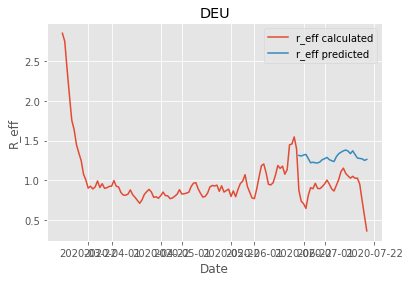

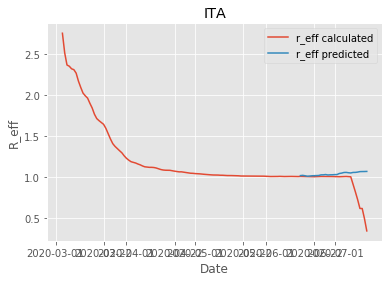

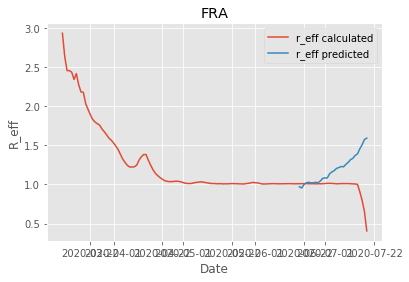

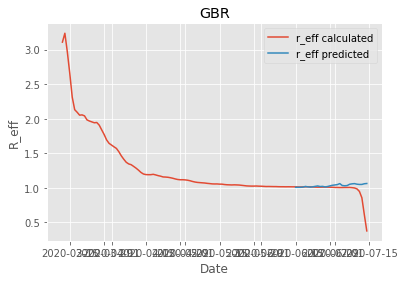

In [26]:
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
import seaborn as sbs
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

for country in country_codes:
    #country="GBR"
    name=dfMapping[dfMapping.ADM0_A3 == country].name.values[0]
    print(name)
# load features
    df_cases_feats=load_obj("cases_feats")[country]
    df_ox_feats=load_obj("stringency_feats")[country]
    df_mob_feats=load_obj("mobility_feats")[country]
# load label
    if country=="DEU":
        r_eff=pd.read_csv("/project_data/data_asset/venus/r_eff_numbers_germany/r_eff.csv")
    else:
        r_eff=pd.read_csv("/project_data/data_asset/venus/r_eff_numbers_globally/r_eff"+name+"global_delay_distr.csv")
        
# merge the dataframes with days from onset as index (days from onset = 100 cases in country)
# build the df for the auto ai experiment
    merge1=pd.merge(df_ox_feats,df_mob_feats,how="right",right_index=True,left_index=True)
    feats=pd.merge(df_cases_feats,merge1,how="right",right_index=True,left_index=True)
    feats.set_index("date",inplace=True)
    feats.index=pd.to_datetime(feats.index,format="%Y-%m-%d")
    if country=="DEU":
        label=pd.DataFrame(index=r_eff.index,data=list(r_eff["Germany"]),columns=["r_eff"])
    else:
        label=pd.DataFrame(index=r_eff.index,data=list(r_eff["r_eff"]),columns=["r_eff"])
    label.index=pd.to_datetime(label.index,format="%Y-%m-%d")
# prediction of r_eff for X days
# reindex to shift data X days in time, apply timedelta of -X days to sort the r_eff values of today in the row with the features of X days ago 
    X=7
    label.index=label.index - timedelta(days=X)
    feat_cols=feats.columns
    label_col=label.columns
# merge the dataframe with features and label    
    df_model=pd.merge(feats,label,how="left",right_index=True,left_index=True)
    df_model.dropna(inplace=True)
# feature selection
    selector = SelectKBest(f_regression, k=20)
    selector.fit(df_model[feat_cols], df_model[label_col])
# Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    features_df_new = df_model.iloc[:,cols]
    new_feat_cols=features_df_new.columns
    df_model=pd.merge(features_df_new,df_model[label_col],how="left",right_index=True,left_index=True)    
# train the model
# do train / test split just by not training on the last 10 days
# for how many days back into the trainingdata do I want the prediction
    test=30
# Overlap of training / test --> just for plotting
    overlap=0
    train_date=max(df_model.index)-timedelta(days=test)
    model = LinearRegression()
    ml = model.fit(df_model[df_model.index<=train_date][new_feat_cols].values,
               df_model[df_model.index<=train_date][label_col])
    r_eff_predicted= ml.predict(df_model[df_model.index>(train_date-timedelta(days=overlap))][new_feat_cols].values)
    
# for plotting I add the +X days timedelta to get the correct data displayed

    plt.figure()
    plt.plot(df_model.index+timedelta(days=X),df_model[label_col],label="r_eff calculated")
    plt.plot(df_model[df_model.index>(train_date-timedelta(days=overlap))].index+timedelta(days=X),r_eff_predicted,label="r_eff predicted")
    plt.title(country)
    plt.xlabel("Date")
    plt.ylabel("R_eff")
    plt.legend()
    #break